In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim


### Exploratory Analysis of Animation Studio Dataset

In [ ]:
df = pd.read_csv("data/animation_studios.csv")
df.columns
df.head(5)
df_clean = df.drop(columns=["Notes and sources"])
df_clean = df_clean[df_clean["Country"].notnull()]

# Filter to remove unknown founding year
df_clean = df_clean[df_clean["Founded"].apply(lambda x: str(x).isdigit())]
df_clean["Founded"] = df_clean["Founded"].astype(int)

# Preview
df_clean.shape


(340, 3)

In [3]:
from time import sleep

# Load cleaned data
df = pd.read_csv("data/animation_studios.csv")
df_clean = df.drop(columns=["Notes and sources"])
df_clean = df_clean[df_clean["Country"].notnull()]
df_clean = df_clean[df_clean["Founded"].apply(lambda x: str(x).isdigit())]
df_clean["Founded"] = df_clean["Founded"].astype(int)

# Unique countries
countries = df_clean["Country"].drop_duplicates().to_frame()

# Geocoder setup
geolocator = Nominatim(user_agent="animation_map")
latitudes = []
longitudes = []

for country in countries["Country"]:
    try:
        location = geolocator.geocode(country)
        if location:
            latitudes.append(location.latitude)
            longitudes.append(location.longitude)
        else:
            latitudes.append(None)
            longitudes.append(None)
    except Exception as e:
        latitudes.append(None)
        longitudes.append(None)
    sleep(1)  # Be polite to the API

# Merge coords
countries["lat"] = latitudes
countries["lon"] = longitudes

# Merge back to studios
df_final = df_clean.merge(countries, on="Country", how="left")

# Drop missing coords
df_final = df_final.dropna(subset=["lat", "lon"])

# Export to CSV
df_final.to_csv("data/studios_with_coords.csv", index=False)


In [20]:
with open("data/studios.csv", "w") as f:
    f.write("Studio,Country,Founded\n")
    for index, row in df_clean.iterrows():
        f.write(f"{row['Studio']},{row['Country']},{row['Founded']}\n")



#### Basic Details 

In [5]:
print("Entries in DF:", df.shape[0])
print("DF Columns:", ", ".join(df.columns))
df

Entries in DF: 348
DF Columns: Studio, Country, Founded, Notes and sources


,Studio,Country,Founded,Notes and sources
0,Animoon,Poland,?,[1]
1,Sun Creature Studio,Denmark,2014,NaN
2,Copenhagen Bombay,Denmark,2006,NaN
3,Honeydew Studios,Australia,2009,NaN
4,Dockhus Animation,Sweden,?,[2]
...,...,...,...,...
343,Xyzoo Animation,South Africa,1991,NaN
344,Yowza! Animation,Canada,1996,NaN
345,Zagreb school of animated films,Croatia,1956,NaN
346,Zexcs,Japan,1998,NaN


In [6]:
# Isolating popular studios (i.e. Pixar, Disney, DreamWorks, etc.)
popular_studios = df[df["Studio"].isin(["Pixar", "Disney", "DreamWorks", "Illumination", "Blue Sky", "Sony", "Paramount", "Warner Bros."])]
popular_studios

# This data-set only includes studios that uniquely produced animations.

,Studio,Country,Founded,Notes and sources
134,Illumination,United States,2007,Subsidiary of Comcast
221,Pixar,United States,1986,Subsidiary of The Walt Disney Company; made th...


#### Handling NaNs

In [7]:
# Dropping Notes/Sources Column due to irrelevance

df = df.drop("Notes and sources", axis = 1)

In [8]:
df["Country"].replace("?", np.nan, inplace=True)
df["Founded"].replace("?", np.nan, inplace=True)

print(df["Country"].isna().sum())
print(df["Founded"].isna().sum())

df.dropna(subset=["Founded"], inplace=True)

df

0
8


,Studio,Country,Founded
1,Sun Creature Studio,Denmark,2014
2,Copenhagen Bombay,Denmark,2006
3,Honeydew Studios,Australia,2009
5,Zigzag Animation,Sweden,1985
6,Krátký Film Praha,Czech Republic,1957
...,...,...,...
343,Xyzoo Animation,South Africa,1991
344,Yowza! Animation,Canada,1996
345,Zagreb school of animated films,Croatia,1956
346,Zexcs,Japan,1998


#### Basis Statistics: Countries

In [9]:
unq_countries = df["Country"].unique()
print("Unique Countries:", unq_countries.shape)

Unique Countries: (38,)


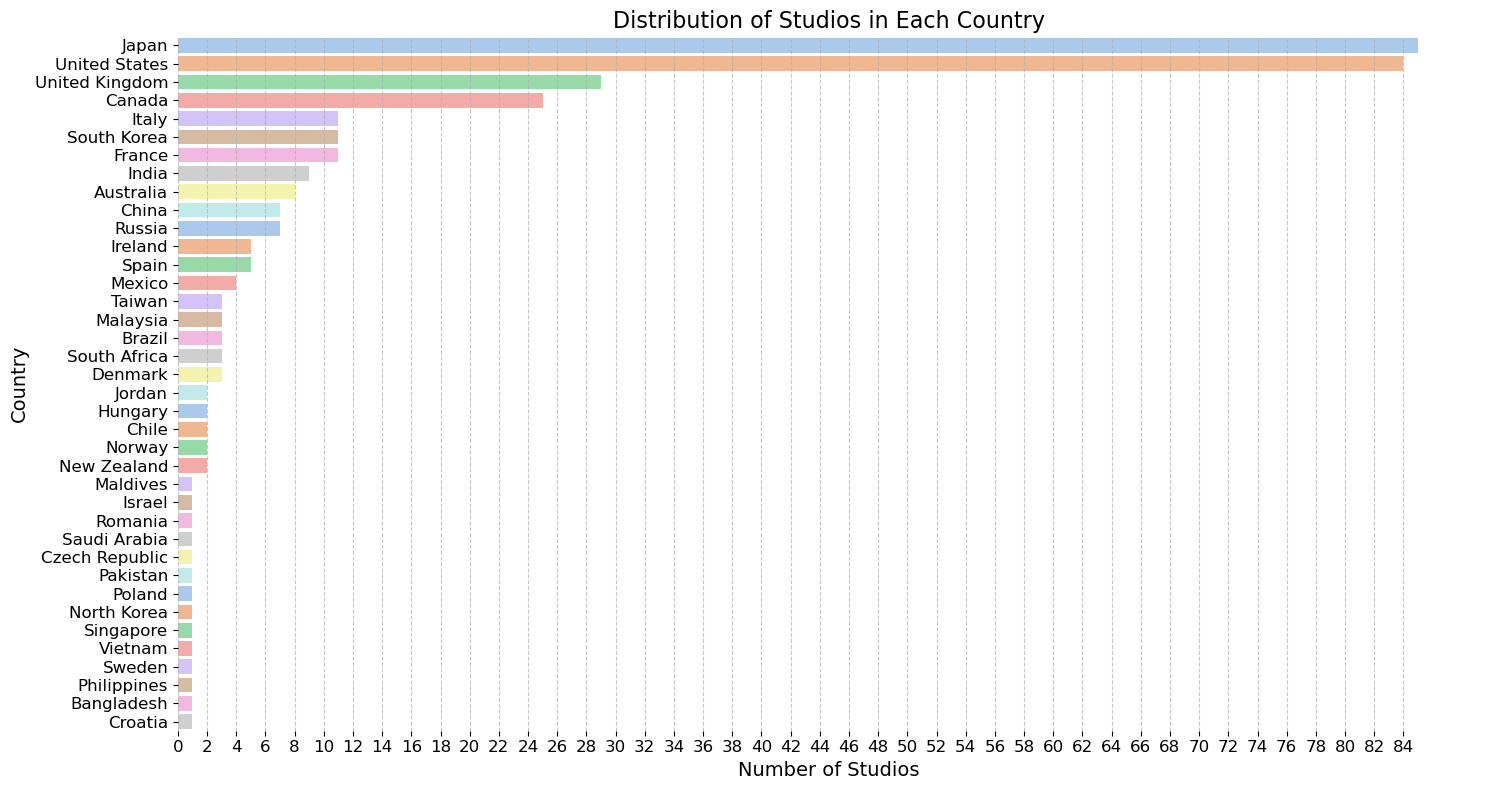

In [10]:
plt.figure(figsize=(15, 8))
sns.countplot(y='Country', data=df, order=df['Country'].value_counts().index, palette='pastel')
plt.title('Distribution of Studios in Each Country', fontsize=16)
plt.xticks(ticks=np.arange(0, df['Country'].value_counts().max() + 1, 2))
sns.despine(left=True, bottom=True)
plt.grid(axis='x', linestyle='--', alpha=0.7)
sns.set_palette("husl")
plt.xlabel('Number of Studios', fontsize=14)
plt.ylabel('Country', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('images/studio_country_distribution.png')
plt.show()

#### Basis Statistics: Countries

In [11]:
unq_founded = df["Founded"].unique()
print("Earliest Founding:", unq_founded.min())
print("Latest Founding:", unq_founded.max())


Earliest Founding: 1923
Latest Founding: 2021


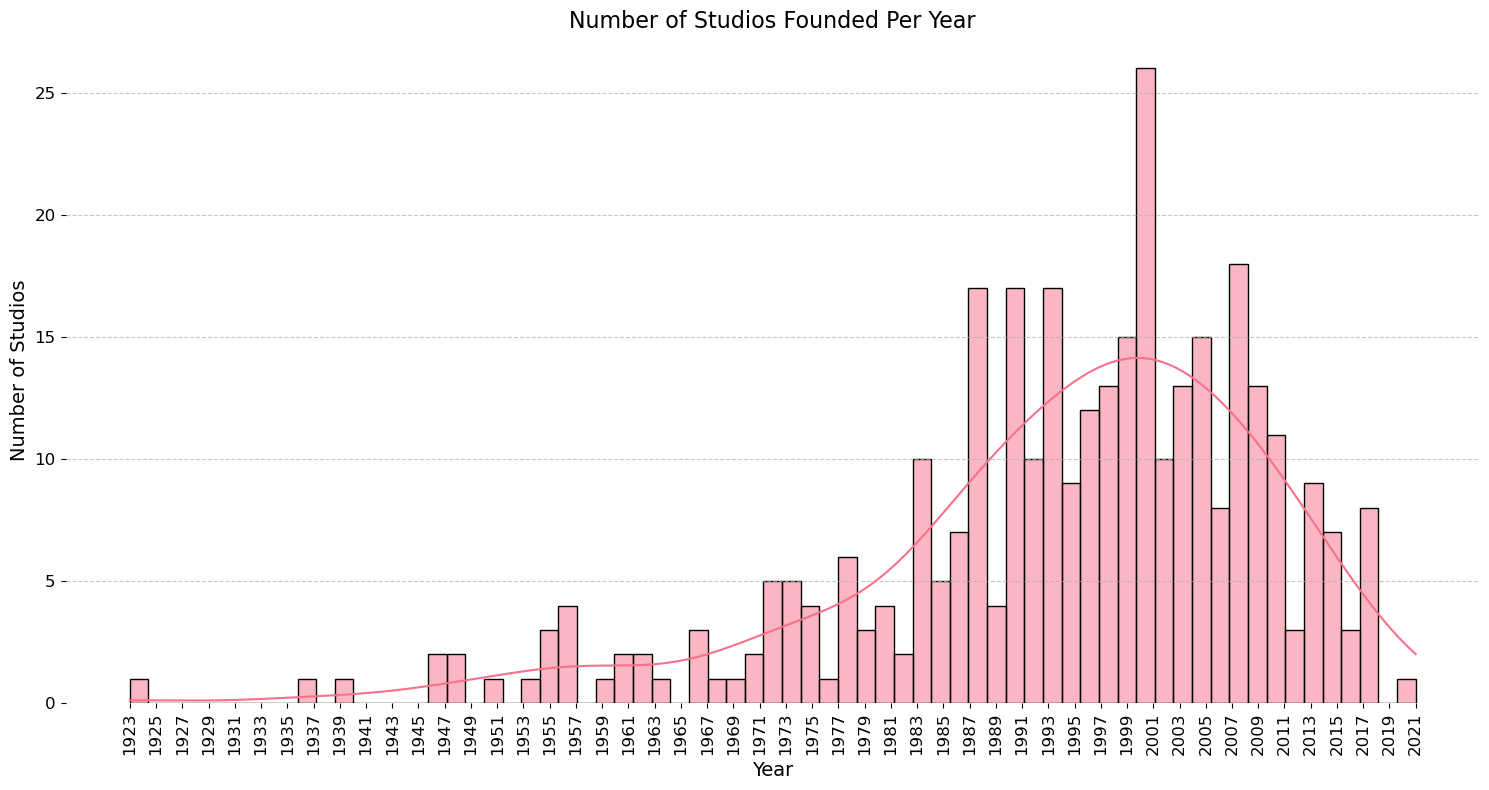

In [12]:
plt.figure(figsize=(15, 8))
sns.histplot(df['Founded'].astype(int), bins=len(unq_founded), kde=True)
plt.title('Number of Studios Founded Per Year',fontsize=16)
plt.xticks(rotation=90)
plt.xlabel('Year', fontsize=14)
plt.xticks(ticks=np.arange(int(unq_founded.min()), int(unq_founded.max()) + 1, 2))
plt.ylabel('Number of Studios', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
sns.despine(left=True, bottom=True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('images/studio_founded_distribution.png')
plt.show()

In [ ]:
# Studio stats
studio_counts = df['Country'].value_counts().reset_index()
studio_counts.columns = ['country', 'studio_count']
studio_counts['studio_pct'] = studio_counts['studio_count'] / studio_counts['studio_count'].sum() * 100

# Movie stats
top_genre = df_movies.groupby('country')['genre'].agg(lambda x: x.mode()[0])
top_movie = df_movies.groupby('country')['title'].agg(lambda x: x.iloc[0])
avg_rating = df_movies.groupby('country')['rating'].mean()
poster_url = df_movies.groupby('country')['poster_url'].agg(lambda x: x.iloc[0])

# Merge
summary = studio_counts.set_index('country').join([top_genre, top_movie, avg_rating, poster_url])
summary.columns = ['studio_count', 'studio_pct', 'top_genre', 'top_movie', 'avg_rating', 'poster_url']
summary.reset_index(inplace=True)

# Save
summary.to_csv("data/animation_country_summary.csv", index=False)
